In [27]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from warnings import filterwarnings
filterwarnings('ignore')

file_path = Path(r"/home/plorenc/Desktop/AiR_ISS/ML/jena_climate_2009_2016.csv/jena_climate_2009_2016.csv")

df = pd.read_csv(file_path)

df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


<Axes: xlabel='Date Time'>

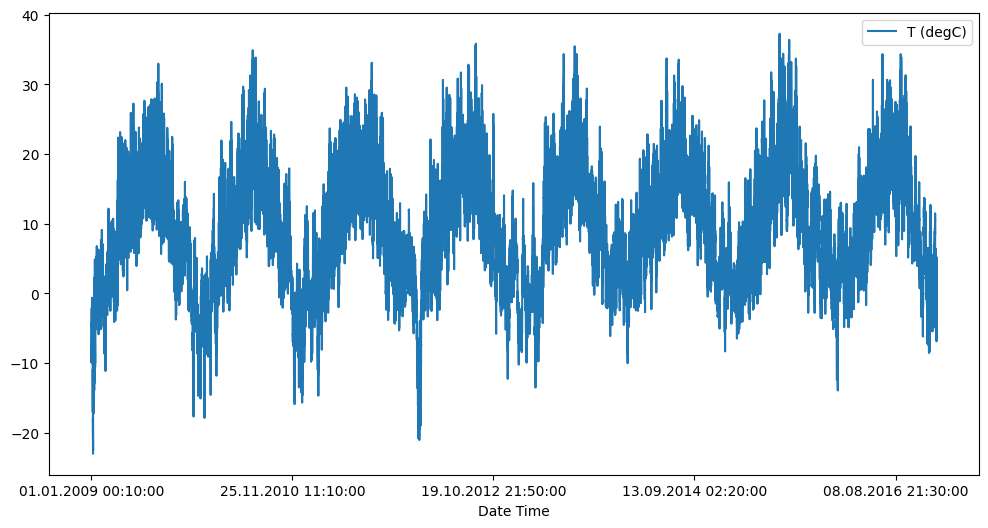

In [28]:
df.plot(x='Date Time', y='T (degC)', figsize=(12, 6))

In [29]:
from sklearn.preprocessing import StandardScaler

train_df = df.loc[:len(df)*0.8]
test_df = df.loc[len(df)*0.8:]

sc = StandardScaler()
scaled_train = sc.fit_transform(train_df[['T (degC)']])
scaled_test = sc.transform(test_df[['T (degC)']])

### Generator danych

In [30]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.utils import Sequence


class DataGen(Sequence):
    def __init__(self, data, lookback, delay, batch_size, step=1):
        self.data = data
        self.lookback = lookback
        self.delay = delay
        self.batch_size = batch_size
        self.step = step

        self.max_index = len(data) - delay
        self.indices = np.arange(lookback, self.max_index)

    def __len__(self):
        return len(self.indices) // self.batch_size

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size : (idx + 1) * self.batch_size]
        X = np.zeros((len(batch_indices), self.lookback // self.step, 1))
        y = np.zeros((len(batch_indices), ))

        for i, index in enumerate(batch_indices):
            start = index - self.lookback
            end = index
            X[i] = np.reshape(self.data[start:end:self.step], (-1, 1))
            y[i] = self.data[index + self.delay]

        return X, y

In [31]:
train_dataloader = DataGen(scaled_train, lookback=400, delay=50, batch_size=32)
test_dataloader = DataGen(scaled_test, lookback=400, delay=50, batch_size=32)

In [32]:
from keras import layers
import tensorflow as tf

class SeqModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1d_1 = layers.Conv1D(32, kernel_size=5, activation='relu')
        self.conv1d_2 = layers.Conv1D(64, kernel_size=5, activation='relu')

        self.gru_1 = layers.GRU(units=10, return_sequences=True)
        self.gru_2 = layers.GRU(units=10)

        self.fc = layers.Dense(1)

    def call(self, inputs):
        x = self.conv1d_1(inputs)
        x = self.conv1d_2(x)
        x = self.gru_1(x)
        x = self.gru_2(x)

        return self.fc(x)

In [34]:
import tensorflow.keras.backend as K

def r2_keras(y_true, y_pred):
    y_true = K.cast(y_true, dtype='float32')
    y_pred = K.cast(y_pred, dtype='float32')
    
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    
    return 1 - SS_res / (SS_tot + K.epsilon())


model = SeqModel()
model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[
        tf.keras.metrics.RootMeanSquaredError(name="rmse"),
        r2_keras
    ]
)

history = model.fit(
    train_dataloader,
    validation_data=test_dataloader,
    epochs=20
)


Epoch 1/20


 2734/10497 ━━━━━━━━━━━━━━━━━━━━ 21:15 164ms/step - loss: 0.3572 - r2_keras: -3161.8516 - rmse: 0.5972

KeyboardInterrupt: 